## Interactive Plotly Visualizations

# Feature Activation Comparison

This notebook compares feature activations between personal_general and personal/uploads experiments, filtering for active features and combining the results with proper descriptions.

In [36]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from typing import List, Dict, Tuple

print("Libraries imported successfully")

Libraries imported successfully


## Configuration

In [37]:
# Paths
PERSONAL_GENERAL_DIR = "./results/personal_general"
PERSONAL_UPLOADS_DIR = "./results/personal/uploads"
OUTPUT_FILE = "active_personal_features_universal_prompts.csv"

# Activation threshold (features with activation_mean > 0 are considered active)
ACTIVATION_THRESHOLD = 0.0

print(f"Personal general directory: {PERSONAL_GENERAL_DIR}")
print(f"Personal uploads directory: {PERSONAL_UPLOADS_DIR}")
print(f"Output file: {OUTPUT_FILE}")
print(f"Activation threshold: {ACTIVATION_THRESHOLD}")

Personal general directory: ./results/personal_general
Personal uploads directory: ./results/personal/uploads
Output file: active_personal_features_universal_prompts.csv
Activation threshold: 0.0


## Find Matching Experiments

In [38]:
def find_matching_experiments():
    """Find experiments that exist in both personal_general and personal/uploads directories."""
    
    # Get CSV files from both directories
    general_files = set()
    uploads_files = set()
    
    if os.path.exists(PERSONAL_GENERAL_DIR):
        general_files = {f for f in os.listdir(PERSONAL_GENERAL_DIR) if f.endswith('.csv')}
    
    if os.path.exists(PERSONAL_UPLOADS_DIR):
        uploads_files = {f for f in os.listdir(PERSONAL_UPLOADS_DIR) if f.endswith('.csv')}
    
    # Find matching experiments
    matching_experiments = general_files.intersection(uploads_files)
    
    print(f"Found {len(general_files)} files in personal_general")
    print(f"Found {len(uploads_files)} files in personal/uploads")
    print(f"Found {len(matching_experiments)} matching experiments")
    
    if matching_experiments:
        print("\nMatching experiments:")
        for exp in sorted(matching_experiments):
            print(f"  - {exp}")
    else:
        print("\nNo matching experiments found!")
    
    return sorted(matching_experiments)

matching_experiments = find_matching_experiments()

Found 10 files in personal_general
Found 10 files in personal/uploads
Found 10 matching experiments

Matching experiments:
  - llama_trainer1_layer11_asst.csv
  - llama_trainer1_layer11_endheader.csv
  - llama_trainer1_layer11_newline.csv
  - llama_trainer1_layer15_asst.csv
  - llama_trainer1_layer15_endheader.csv
  - llama_trainer1_layer15_newline.csv
  - qwen_trainer1_layer11_asst.csv
  - qwen_trainer1_layer11_newline.csv
  - qwen_trainer1_layer15_asst.csv
  - qwen_trainer1_layer15_newline.csv


## Process Each Experiment

In [39]:
def process_experiment(experiment_file: str) -> pd.DataFrame:
    """Process a single experiment by comparing general and uploads data."""
    
    print(f"\nProcessing experiment: {experiment_file}")
    
    # Load both CSV files
    general_path = os.path.join(PERSONAL_GENERAL_DIR, experiment_file)
    uploads_path = os.path.join(PERSONAL_UPLOADS_DIR, experiment_file)
    
    try:
        general_df = pd.read_csv(general_path)
        uploads_df = pd.read_csv(uploads_path)
        
        print(f"  General data: {len(general_df)} features")
        print(f"  Uploads data: {len(uploads_df)} features")
        
    except Exception as e:
        print(f"  Error loading files: {e}")
        return pd.DataFrame()
    
    # Filter general data for active features (activation_mean > threshold)
    active_general = general_df[general_df['activation_mean'] > ACTIVATION_THRESHOLD].copy()
    print(f"  Active features in general: {len(active_general)}")
    
    if len(active_general) == 0:
        print(f"  No active features found in {experiment_file}")
        return pd.DataFrame()
    
    # Create a lookup dictionary for uploads data
    uploads_lookup = {}
    for _, row in uploads_df.iterrows():
        feature_id = row['feature_id']
        uploads_lookup[feature_id] = {
            'chat_desc': row.get('chat_desc', ''),
            'pt_desc': row.get('pt_desc', ''),
            'type': row.get('type', ''),
            'personal_mean': row.get('assistant_mean', ''),
            'personal_cohens_d': row.get('cohens_d', '')
        }
    
    # Combine data: use general activation data but uploads descriptions and personal stats
    combined_data = []
    
    for _, row in active_general.iterrows():
        feature_id = row['feature_id']
        
        # Get data from uploads if available
        if feature_id in uploads_lookup:
            uploads_data = uploads_lookup[feature_id]
        else:
            # Fallback to general data (likely empty)
            uploads_data = {
                'chat_desc': row.get('chat_desc', ''),
                'pt_desc': row.get('pt_desc', ''),
                'type': row.get('type', ''),
                'personal_mean': '',
                'personal_cohens_d': ''
            }
        
        # Create combined record
        combined_record = {
            'feature_id': feature_id,
            'general_activation_mean': row['activation_mean'],
            'general_activation_max': row['activation_max'],
            'general_activation_min': row['activation_min'],
            'personal_mean': uploads_data['personal_mean'],
            'personal_cohens_d': uploads_data['personal_cohens_d'],
            'chat_desc': uploads_data['chat_desc'],
            'pt_desc': uploads_data['pt_desc'],
            'type': uploads_data['type'],
            'link': row.get('link', ''),
            'source': experiment_file
        }
        
        combined_data.append(combined_record)
    
    result_df = pd.DataFrame(combined_data)
    print(f"  Combined features: {len(result_df)}")
    
    return result_df

# Process all matching experiments
all_combined_data = []

for experiment in matching_experiments:
    experiment_data = process_experiment(experiment)
    if not experiment_data.empty:
        all_combined_data.append(experiment_data)

print(f"\nProcessed {len(all_combined_data)} experiments successfully")


Processing experiment: llama_trainer1_layer11_asst.csv
  General data: 1 features
  Uploads data: 1 features
  Active features in general: 0
  No active features found in llama_trainer1_layer11_asst.csv

Processing experiment: llama_trainer1_layer11_endheader.csv
  General data: 4 features
  Uploads data: 4 features
  Active features in general: 0
  No active features found in llama_trainer1_layer11_endheader.csv

Processing experiment: llama_trainer1_layer11_newline.csv
  General data: 6 features
  Uploads data: 6 features
  Active features in general: 1
  Combined features: 1

Processing experiment: llama_trainer1_layer15_asst.csv
  General data: 2 features
  Uploads data: 2 features
  Active features in general: 1
  Combined features: 1

Processing experiment: llama_trainer1_layer15_endheader.csv
  General data: 6 features
  Uploads data: 6 features
  Active features in general: 2
  Combined features: 2

Processing experiment: llama_trainer1_layer15_newline.csv
  General data: 7 fe

## Combine All Results

In [40]:
if all_combined_data:
    # Combine all experiment data
    final_combined_df = pd.concat(all_combined_data, ignore_index=True)
    
    # Sort by source (to group experiments) and then by general_activation_mean descending
    final_combined_df = final_combined_df.sort_values(['source', 'general_activation_mean'], ascending=[True, False])
    
    print(f"\nFinal combined dataset:")
    print(f"  Total features: {len(final_combined_df)}")
    print(f"  Unique features: {final_combined_df['feature_id'].nunique()}")
    print(f"  Experiments: {final_combined_df['source'].nunique()}")
    
    # Show statistics
    print(f"\nActivation statistics:")
    print(f"  Mean activation: {final_combined_df['general_activation_mean'].mean():.4f}")
    print(f"  Max activation: {final_combined_df['general_activation_mean'].max():.4f}")
    print(f"  Min activation: {final_combined_df['general_activation_mean'].min():.4f}")
    
    # Show features per experiment
    print(f"\nFeatures per experiment:")
    source_counts = final_combined_df['source'].value_counts()
    for source, count in source_counts.items():
        print(f"  {source}: {count} features")
    
else:
    print("\nNo data to combine!")
    final_combined_df = pd.DataFrame()


Final combined dataset:
  Total features: 19
  Unique features: 19
  Experiments: 7

Activation statistics:
  Mean activation: 0.4530
  Max activation: 4.6284
  Min activation: 0.0029

Features per experiment:
  qwen_trainer1_layer11_asst.csv: 5 features
  qwen_trainer1_layer11_newline.csv: 5 features
  qwen_trainer1_layer15_newline.csv: 4 features
  llama_trainer1_layer15_endheader.csv: 2 features
  llama_trainer1_layer11_newline.csv: 1 features
  llama_trainer1_layer15_asst.csv: 1 features
  qwen_trainer1_layer15_asst.csv: 1 features


## Save Results

In [41]:
if not final_combined_df.empty:
    # Save to CSV
    final_combined_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nResults saved to: {OUTPUT_FILE}")
    
    # Show preview
    print(f"\nPreview of top 10 features:")
    preview_df = final_combined_df.head(10)
    print(preview_df[['feature_id', 'general_activation_mean', 'personal_mean', 'chat_desc', 'source']].to_string(index=False))
    
    # Show features with descriptions
    features_with_desc = final_combined_df[final_combined_df['chat_desc'].str.len() > 0]
    print(f"\nFeatures with descriptions: {len(features_with_desc)} / {len(final_combined_df)}")
    
    if len(features_with_desc) > 0:
        print(f"\nTop 5 features with descriptions:")
        desc_preview = features_with_desc.head(5)
        for _, row in desc_preview.iterrows():
            print(f"  Feature {row['feature_id']} (general: {row['general_activation_mean']:.3f}, personal: {row['personal_mean']}): {row['chat_desc']}")
    
    # Show column structure
    print(f"\nFinal column structure:")
    for col in final_combined_df.columns:
        print(f"  - {col}")
    
else:
    print("\nNo results to save!")


Results saved to: active_personal_features_universal_prompts.csv

Preview of top 10 features:
 feature_id  general_activation_mean  personal_mean                                                                                                 chat_desc                               source
     126716                 0.054600       0.141682                                                                              newline before nsfw roleplay   llama_trainer1_layer11_newline.csv
      27476                 0.011086       0.115445                            symbols, metaphors, representations (especially in role-playing scenarios) ???      llama_trainer1_layer15_asst.csv
      59035                 0.036272       0.244919                                     instructions for role-playing, requirements, schema, templates, rules llama_trainer1_layer15_endheader.csv
      47776                 0.002858       0.154815                                                             programmatic 

## Visualization: Feature Activation Comparison

Data for plotting: 19 features with valid personal_mean values
Features with missing personal_mean: 0


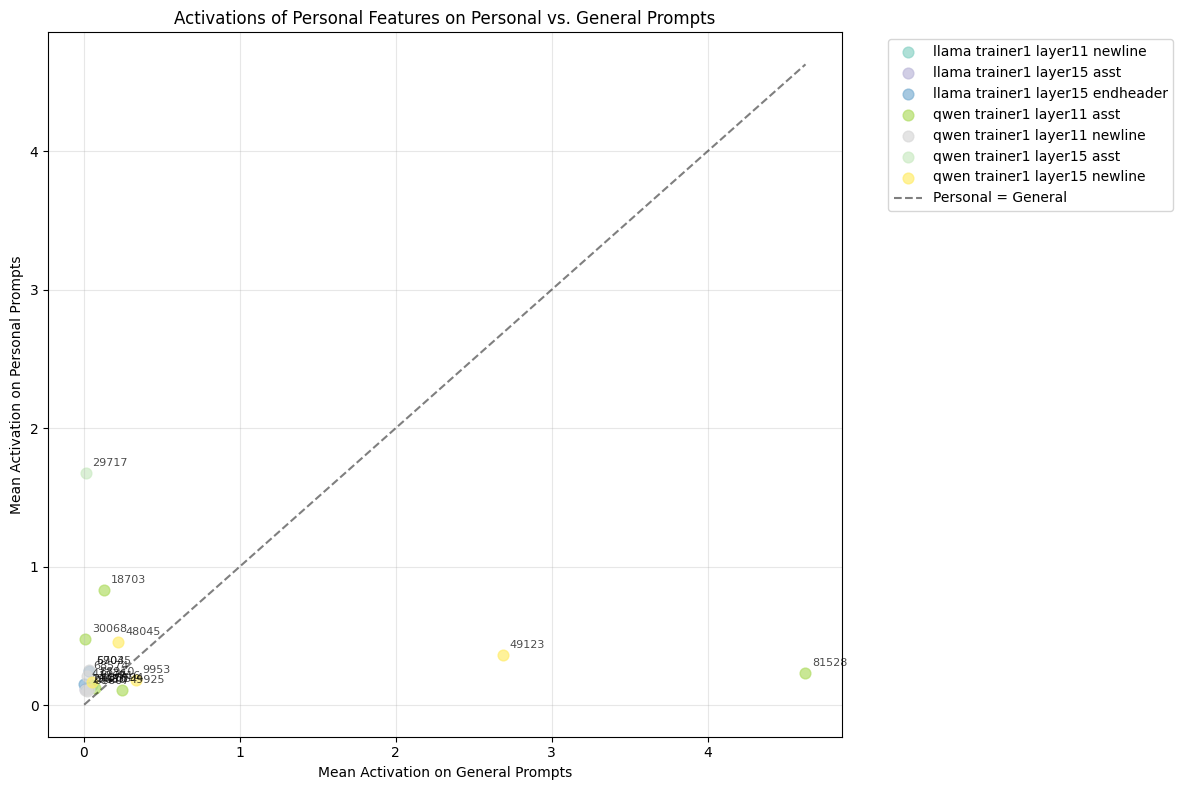

\nScatter Plot Insights:
  Features more active in personal context: 15
  Features more active in general context: 4
  Biggest personal boost: Feature 29717


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

if not final_combined_df.empty:
    # Convert personal_mean to numeric, handling any string values
    final_combined_df['personal_mean_numeric'] = pd.to_numeric(final_combined_df['personal_mean'], errors='coerce')
    
    # Filter out rows where personal_mean couldn't be converted
    plot_df = final_combined_df[final_combined_df['personal_mean_numeric'].notna()].copy()
    
    print(f"Data for plotting: {len(plot_df)} features with valid personal_mean values")
    print(f"Features with missing personal_mean: {len(final_combined_df) - len(plot_df)}")
    
    if len(plot_df) > 0:
        # Create color mapping for sources
        unique_sources = plot_df['source'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_sources)))
        source_colors = dict(zip(unique_sources, colors))
        
        # Static matplotlib plot
        plt.figure(figsize=(12, 8))
        
        for source in unique_sources:
            source_data = plot_df[plot_df['source'] == source]
            
            # Plot scatter points
            plt.scatter(source_data['general_activation_mean'], 
                       source_data['personal_mean_numeric'],
                       c=[source_colors[source]], 
                       label=source.replace('_', ' ').replace('.csv', ''),
                       alpha=0.7, s=60)
            
            # Add feature ID labels for points
            for _, row in source_data.iterrows():
                plt.annotate(f"{row['feature_id']}", 
                           (row['general_activation_mean'], row['personal_mean_numeric']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.7)
        
        # Add diagonal reference line (where personal = general)
        max_val = max(plot_df['general_activation_mean'].max(), plot_df['personal_mean_numeric'].max())
        min_val = min(plot_df['general_activation_mean'].min(), plot_df['personal_mean_numeric'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Personal = General')
        
        plt.xlabel('Mean Activation on General Prompts')
        plt.ylabel('Mean Activation on Personal Prompts')
        plt.title('Activations of Personal Features on Personal vs. General Prompts')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print some insights
        print(f"\\nScatter Plot Insights:")
        above_diagonal = plot_df[plot_df['personal_mean_numeric'] > plot_df['general_activation_mean']]
        below_diagonal = plot_df[plot_df['personal_mean_numeric'] < plot_df['general_activation_mean']]
        
        print(f"  Features more active in personal context: {len(above_diagonal)}")
        print(f"  Features more active in general context: {len(below_diagonal)}")
        
        if len(above_diagonal) > 0:
            print(f"  Biggest personal boost: Feature {above_diagonal.loc[above_diagonal['personal_mean_numeric'] - above_diagonal['general_activation_mean'] == (above_diagonal['personal_mean_numeric'] - above_diagonal['general_activation_mean']).max(), 'feature_id'].iloc[0]}")
        
    else:
        print("No valid data for plotting scatter plot")
        
else:
    print("No data available for plotting")

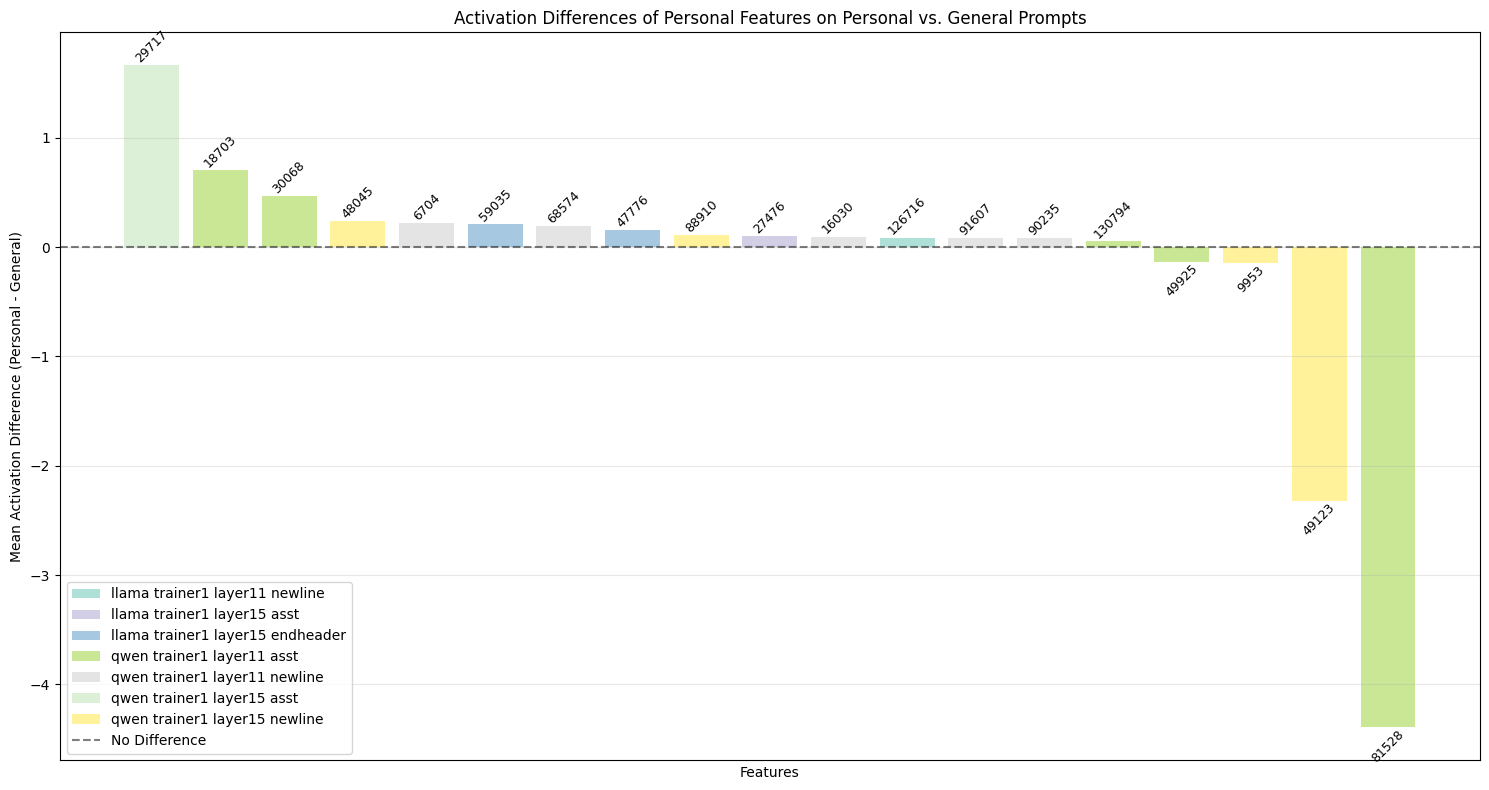

\nDifference Plot Insights:
  Features more active in personal context: 15
  Features more active in general context: 4
  Mean difference: -0.1339
  Largest positive difference: 1.6620
  Largest negative difference: -4.3936
  Biggest personal boost: Feature 29717 (+1.6620)
    Description: AI chatbot response of "i'm a/an" to questions of "who are you"
  Biggest general boost: Feature 81528 (-4.3936)
    Description: "assistant" header token after being asked to do a writing or copyediting task


In [47]:
if not final_combined_df.empty and len(plot_df) > 0:
    # Plot 2: Difference Plot - Personal vs General Activation Difference
    
    # Calculate activation difference (personal - general)
    plot_df['activation_difference'] = plot_df['personal_mean_numeric'] - plot_df['general_activation_mean']
    
    # Sort by activation difference (highest to lowest)
    plot_df_sorted = plot_df.sort_values('activation_difference', ascending=False)
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Create colors for each bar based on source
    unique_sources = plot_df['source'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_sources)))
    source_colors = dict(zip(unique_sources, colors))
    
    # Get colors for each bar
    bar_colors = [source_colors[source] for source in plot_df_sorted['source']]
    
    # Plot bars
    bars = plt.bar(range(len(plot_df_sorted)), 
                  plot_df_sorted['activation_difference'],
                  color=bar_colors, 
                  alpha=0.7)
    
    # Add feature ID labels on bars
    for i, (_, row) in enumerate(plot_df_sorted.iterrows()):
        plt.annotate(f"{row['feature_id']}", 
                    (i, row['activation_difference']),
                    ha='center', va='bottom' if row['activation_difference'] > 0 else 'top',
                    fontsize=9, rotation=45)
    
    # Add horizontal line at y=0 (no difference)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No Difference')
    
    # Create legend for sources
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=source_colors[source], alpha=0.7, 
                                   label=source.replace('_', ' ').replace('.csv', '')) 
                      for source in unique_sources]
    legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, label='No Difference'))
    
    # Formatting
    plt.xlabel('Features')
    plt.ylabel('Mean Activation Difference (Personal - General)')
    plt.title('Activation Differences of Personal Features on Personal vs. General Prompts')
    plt.legend(handles=legend_elements, loc='lower left')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Remove x-axis ticks but keep the label
    plt.xticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print(f"\\nDifference Plot Insights:")
    positive_diff = plot_df[plot_df['activation_difference'] > 0]
    negative_diff = plot_df[plot_df['activation_difference'] < 0]
    
    print(f"  Features more active in personal context: {len(positive_diff)}")
    print(f"  Features more active in general context: {len(negative_diff)}")
    print(f"  Mean difference: {plot_df['activation_difference'].mean():.4f}")
    print(f"  Largest positive difference: {plot_df['activation_difference'].max():.4f}")
    print(f"  Largest negative difference: {plot_df['activation_difference'].min():.4f}")
    
    if len(positive_diff) > 0:
        biggest_personal = positive_diff.loc[positive_diff['activation_difference'].idxmax()]
        print(f"  Biggest personal boost: Feature {biggest_personal['feature_id']} (+{biggest_personal['activation_difference']:.4f})")
        print(f"    Description: {biggest_personal['chat_desc']}")
    
    if len(negative_diff) > 0:
        biggest_general = negative_diff.loc[negative_diff['activation_difference'].idxmin()]
        print(f"  Biggest general boost: Feature {biggest_general['feature_id']} ({biggest_general['activation_difference']:.4f})")
        print(f"    Description: {biggest_general['chat_desc']}")

else:
    print("No valid data for plotting difference plot")

In [65]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc

if not final_combined_df.empty and len(plot_df) > 0:
    # Create consistent color mapping for sources (remove .csv from names)
    unique_sources = sorted(plot_df['source'].unique())
    source_names = [s.replace('.csv', '') for s in unique_sources]
    colors = pc.qualitative.Plotly[:len(unique_sources)]
    source_color_map = dict(zip(unique_sources, colors))
    
    # Create a copy with cleaned source names for display
    plot_df_display = plot_df.copy()
    plot_df_display['source_clean'] = plot_df_display['source'].str.replace('.csv', '')
    
    # Interactive Scatter Plot
    fig_scatter = px.scatter(
        plot_df_display,
        x='general_activation_mean',
        y='personal_mean_numeric',
        color='source_clean',
        color_discrete_map=dict(zip(source_names, colors)),
        hover_data={'chat_desc': True, 'pt_desc': True, 'source_clean': False, 'general_activation_mean': False, 'personal_mean_numeric': False},
        hover_name='feature_id',
        text='feature_id',
        title='Activations of Personal Features on Personal vs. General Prompts',
        labels={
            'general_activation_mean': 'Mean Activation on General Prompts',
            'personal_mean_numeric': 'Mean Activation on Personal Prompts',
            'source_clean': 'Source'
        }
    )
    
    # Update text labels to show feature IDs
    fig_scatter.update_traces(
        textposition="middle right",
        textfont_size=8
    )
    
    # Add diagonal reference line
    max_val = max(plot_df['general_activation_mean'].max(), plot_df['personal_mean_numeric'].max())
    min_val = min(plot_df['general_activation_mean'].min(), plot_df['personal_mean_numeric'].min())
    fig_scatter.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            line=dict(color='black', dash='dash'),
            name='Personal = General',
            hovertemplate='<extra></extra>',
            showlegend=True
        )
    )
    
    # Update layout for better interaction
    fig_scatter.update_layout(
        xaxis_title='Mean Activation on General Prompts',
        yaxis_title='Mean Activation on Personal Prompts',
        height=600,
        width=800,
        hovermode='closest'
    )
    
    # Update hover template to show only chat_desc and pt_desc
    fig_scatter.update_traces(
        hovertemplate='<b>feature_id: %{hovertext}</b><br>' +
                     'chat_desc: %{customdata[0]}<br>' +
                     'pt_desc: %{customdata[1]}<br>' +
                     '<extra></extra>',
        selector=dict(mode='markers+text')
    )
    
    # Save as HTML file
    fig_scatter.write_html("interactive_scatter_feature_activations.html")
    print("Scatter plot saved as: interactive_scatter_feature_activations.html")
    
    fig_scatter.show()
    
else:
    print("No valid data for interactive scatter plot")

Scatter plot saved as: interactive_scatter_feature_activations.html


In [66]:
if not final_combined_df.empty and len(plot_df) > 0:
    # Calculate activation difference (personal - general) if not already done
    if 'activation_difference' not in plot_df.columns:
        plot_df['activation_difference'] = plot_df['personal_mean_numeric'] - plot_df['general_activation_mean']
    
    # Sort by activation difference (highest to lowest)
    plot_df_sorted = plot_df.sort_values('activation_difference', ascending=False).reset_index(drop=True)
    
    # Create a copy with cleaned source names for display
    plot_df_sorted_display = plot_df_sorted.copy()
    plot_df_sorted_display['source_clean'] = plot_df_sorted_display['source'].str.replace('.csv', '')
    
    # Interactive Bar Plot
    fig_bar = px.bar(
        plot_df_sorted_display,
        x=plot_df_sorted_display.index,
        y='activation_difference',
        color='source_clean',
        color_discrete_map=dict(zip(source_names, colors)),
        hover_data={'chat_desc': True, 'pt_desc': True, 'source_clean': False, 'activation_difference': False},
        hover_name='feature_id',
        text='feature_id',
        title='Activation Differences of Personal Features on Personal vs. General Prompts',
        labels={
            'x': 'Features',
            'activation_difference': 'Mean Activation Difference (Personal - General)',
            'source_clean': 'Source'
        }
    )
    
    # Update text labels to show feature IDs on bars
    fig_bar.update_traces(
        textposition="outside",
        textfont_size=9
    )
    
    # Add horizontal line at y=0
    fig_bar.add_hline(y=0, line_dash="dash", line_color="black")
    
    # Update layout - disable zoom and pan for bar plot, remove x-axis numbers
    fig_bar.update_layout(
        xaxis_title='Features',
        yaxis_title='Mean Activation Difference (Personal - General)',
        height=600,
        hovermode='closest',
        xaxis=dict(
            fixedrange=True,  # Disable zoom/pan on x-axis
            showticklabels=False  # Remove x-axis tick labels (numbers)
        ),
        yaxis=dict(fixedrange=True)   # Disable zoom/pan on y-axis
    )
    
    # Update hover template to show only chat_desc and pt_desc
    fig_bar.update_traces(
        hovertemplate='<b>feature_id: %{hovertext}</b><br>' +
                     'chat_desc: %{customdata[0]}<br>' +
                     'pt_desc: %{customdata[1]}<br>' +
                     '<extra></extra>'
    )
    
    # Save as HTML file
    fig_bar.write_html("interactive_bar_feature_activations.html")
    print("Bar plot saved as: interactive_bar_feature_activations.html")
    
    fig_bar.show()
    
else:
    print("No valid data for interactive bar plot")

Bar plot saved as: interactive_bar_feature_activations.html
